In [1]:
# type: ignore
import math
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
from carbs import CARBS
from carbs import CARBSParams
from carbs import LogSpace
from carbs import ObservationInParam
from carbs import ParamDictType

from avalon.common.log_utils import configure_local_logger

# logger.remove()
# logger.add(sys.stdout, level="DEBUG", format="{message}")
configure_local_logger()

param_space_by_name = OrderedDict(
    [
        ("learning_rate", LogSpace()),
        # ("momentum", LogitSpace()),
        ("hidden_dim", LogSpace(is_integer=True, min=2, max=512)),
    ]
)


def run_test_fn(input_in_param: ParamDictType):
    # A noisy function minimized at lr=1e-3, max hidden_dim
    # if input_in_param["learning_rate"] > 1e-3:
    #     return float("inf")
    result = ((math.log10(input_in_param["learning_rate"]) + 3) ** 2 + 0.2) * 512 / input_in_param[
        "hidden_dim"
    ] + np.random.uniform() * 0.1
    return result


initial_params = {"learning_rate": 1e-5, "hidden_dim": 32}  # , "momentum": 0.9}

carbs_params = CARBSParams(
    better_direction_sign=-1,
    is_wandb_logging_enabled=False,
    initial_search_radius=0.5,
    # resample_frequency=-1,
)
carbs = CARBS(carbs_params, param_space_by_name)
carbs.set_search_center(initial_params)

Running CARBS with params CARBSParams(better_direction_sign=-1, seed=0, num_random_samples=4, is_wandb_logging_enabled=False, wandb_params=WandbLoggingParams(project_name=None, group_name=None, run_name=None, run_id=None, is_suggestion_logged=True, is_observation_logged=True, is_search_space_logged=True, root_dir='/mnt/private'), is_saved_on_every_observation=True, initial_search_radius=0.5, exploration_bias=1.0, num_candidates_for_suggestion_per_dim=100, resample_frequency=5, max_cost=None, search_distribution_function=<SearchDistributionFunctionEnum.NORMAL: 'NORMAL'>, min_pareto_cost_fraction=0.2, is_pareto_group_selection_conservative=True, is_expected_improvement_pareto_value_clamped=True, is_expected_improvement_value_always_max=False, outstanding_suggestion_estimator=<OutstandingSuggestionEstimatorEnum.THOMPSON: 'THOMPSON'>)


In [2]:


def plot_and_suggest():
    if len(carbs.observations_in_basic) < carbs.params.num_random_samples:
        return carbs.suggest()
    pareto_observations = np.stack([x.real_number_input for x in carbs._get_pareto_set()])
    observations = np.stack([x.real_number_input for x in carbs.observations_in_basic])
    min_lr, min_hid = observations.min(axis=0)
    max_lr, max_hid = observations.max(axis=0)
    dlr, dhid = (max_lr - min_lr) / 20, (max_hid - min_hid) / 20
    lr_range = np.arange(min_lr - dlr * 4, max_lr + dlr * 10.5, dlr)
    hid_range = np.arange(min_hid - dhid * 4, max_hid + dhid * 10.5, dhid)
    nlr, nhid = lr_range.shape[0], hid_range.shape[0]
    assert nlr == nhid, "Aaargh this is broken for some reason"
    grid_inputs = np.stack(np.meshgrid(lr_range, hid_range), axis=-1).reshape((-1, 2))
    (
        surrogate_model_outputs,
        probabilities,
        ei_value,
        acquisition_function_value,
    ) = carbs.evaluate_candidates(torch.from_numpy(grid_inputs).to(torch.float), (0,), is_rounding_candidates=True)

    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(12, 6)
    cs = axs[0].contourf(
        grid_inputs[:, 0].reshape((nlr, nhid)),
        grid_inputs[:, 1].reshape((nlr, nhid)),
        surrogate_model_outputs.surrogate_output.cpu().numpy().reshape((nlr, nhid)),
    )
    axs[0].scatter(observations[:, 0], observations[:, 1], color="orange")
    axs[0].scatter(pareto_observations[:, 0], pareto_observations[:, 1], color="white")
    fig.colorbar(cs, ax=axs[0])
    axs[0].set_xlim((lr_range[0], lr_range[-1]))
    axs[0].set_ylim((hid_range[0], hid_range[-1]))
    axs[0].set_title("Surrogate function value")

    cs = axs[1].contourf(
        grid_inputs[:, 0].reshape((nlr, nhid)),
        grid_inputs[:, 1].reshape((nlr, nhid)),
        torch.log(torch.clamp(ei_value / surrogate_model_outputs.cost_estimate, min=1e-10))
        .cpu()
        .numpy()
        .reshape((nlr, nhid)),
    )
    prob_max = probabilities.max().item()
    axs[1].contour(
        grid_inputs[:, 0].reshape((nlr, nhid)),
        grid_inputs[:, 1].reshape((nlr, nhid)),
        probabilities.cpu().numpy().reshape((nlr, nhid)),
        levels=[prob_max / 9, prob_max / 1.5],
        colors="w",
        linestyles=("dotted", "dashed"),
    )
    # if surrogate_model_outputs.success_probability.min()[0] < 0.5:
    #     axs[1].contour(
    #         grid_inputs[:, 0].reshape((nlr, nhid)),
    #         grid_inputs[:, 1].reshape((nlr, nhid)),
    #         surrogate_model_outputs.success_probability.numpy().reshape((nlr, nhid)),
    #         levels=[0.5],
    #         colors="r",
    #         linestyles="dashed",
    #     )
    axs[1].scatter(observations[:, 0], observations[:, 1], color="orange")
    axs[1].scatter(pareto_observations[:, 0], pareto_observations[:, 1], color="white")
    fig.colorbar(cs, ax=axs[1])
    axs[1].set_xlim((lr_range[0], lr_range[-1]))
    axs[1].set_ylim((hid_range[0], hid_range[-1]))
    axs[1].set_title("Acquisiton function value")

    suggest_out = carbs.suggest()

    assert len(carbs.outstanding_suggestions) == 1

    suggestion_in_basic = list(carbs.outstanding_suggestions.values())[0].real_number_input

    axs[0].scatter(
        [suggestion_in_basic[0]], [suggestion_in_basic[1]], color="pink", marker="*", s=500, edgecolors="black"
    )
    axs[1].scatter(
        [suggestion_in_basic[0]], [suggestion_in_basic[1]], color="pink", marker="*", s=500, edgecolors="black"
    )
    if len(carbs.failed_observations_in_basic) > 0:
        failed_observations = np.stack([x.real_number_input for x in carbs.failed_observations_in_basic])
        axs[0].scatter(failed_observations[:, 0], failed_observations[:, 1], color="red", marker="x")
        axs[1].scatter(failed_observations[:, 0], failed_observations[:, 1], color="red", marker="x")
    plt.show()
    return suggest_out

/opt/venv/lib/python3.9/site-packages/pyro/contrib/gp/models/gpr.py:81: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1744.)
  Lff = Kff.cholesky()
/opt/venv/lib/python3.9/site-packages/pyro/contrib/gp/util.py:109: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggere

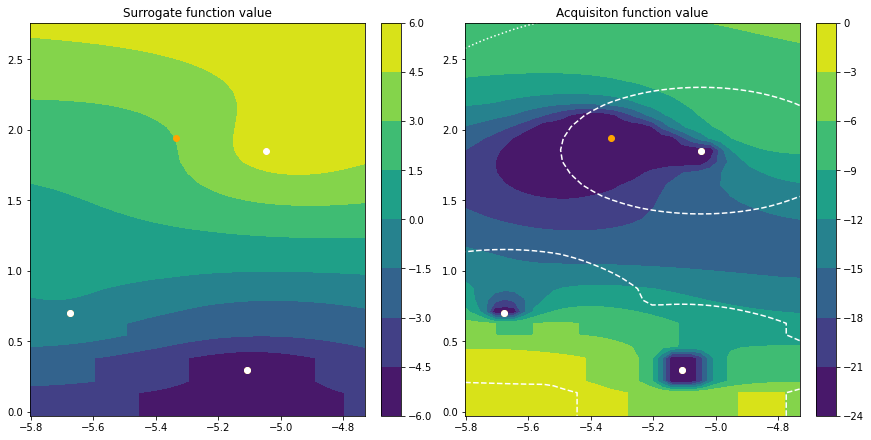

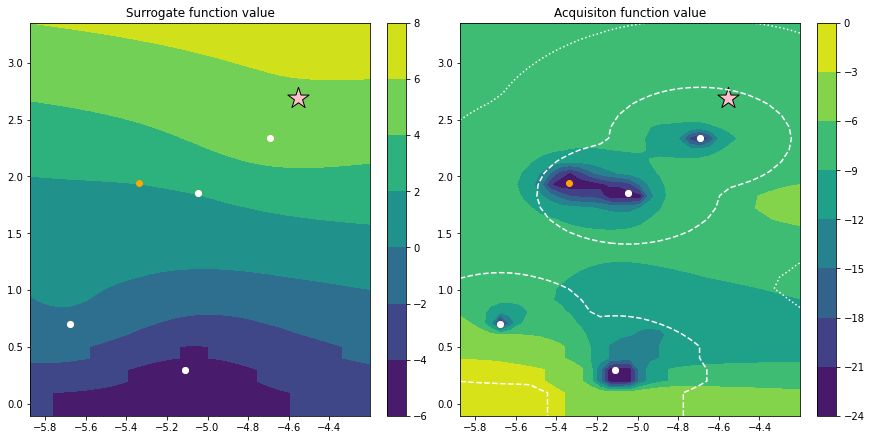

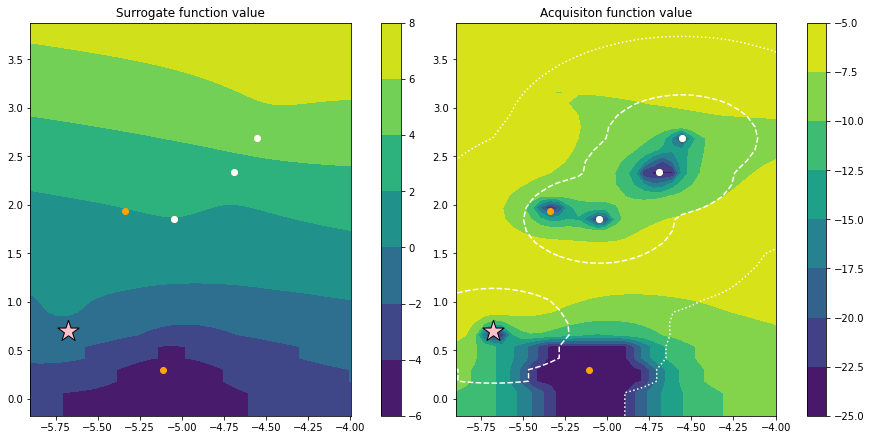

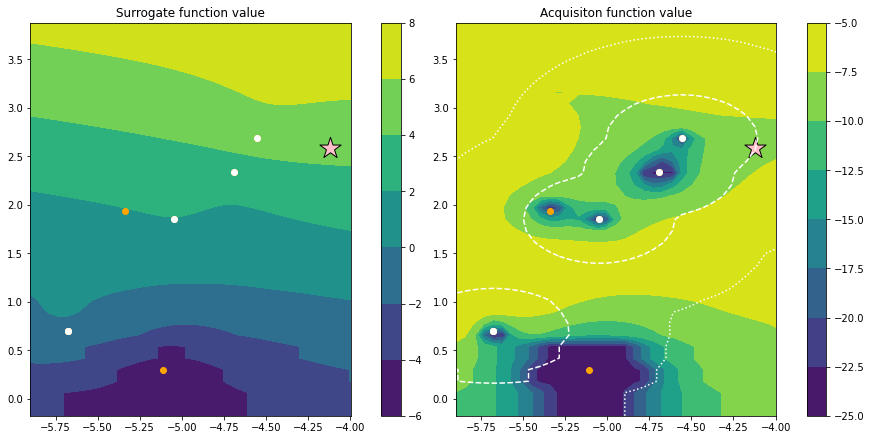

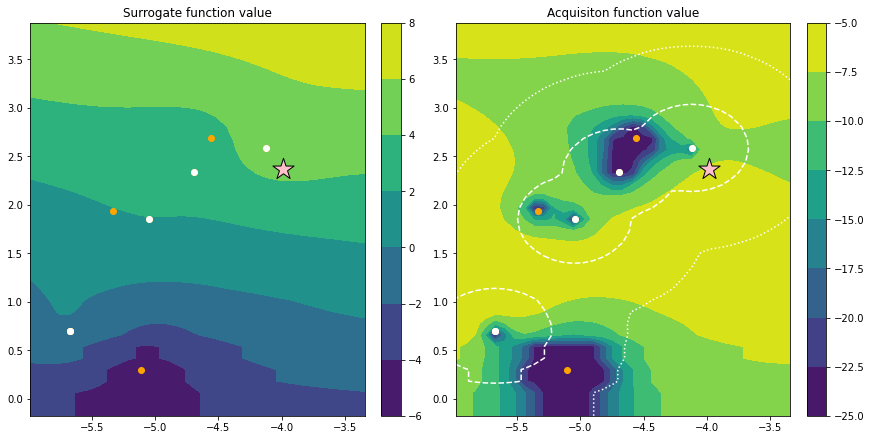

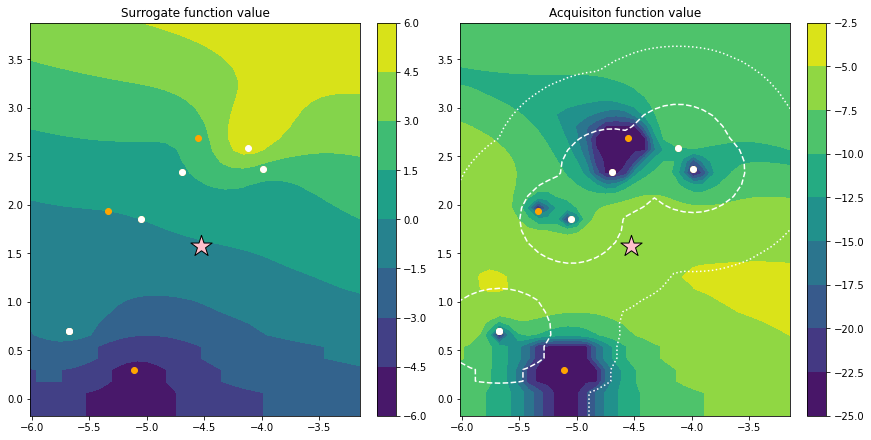

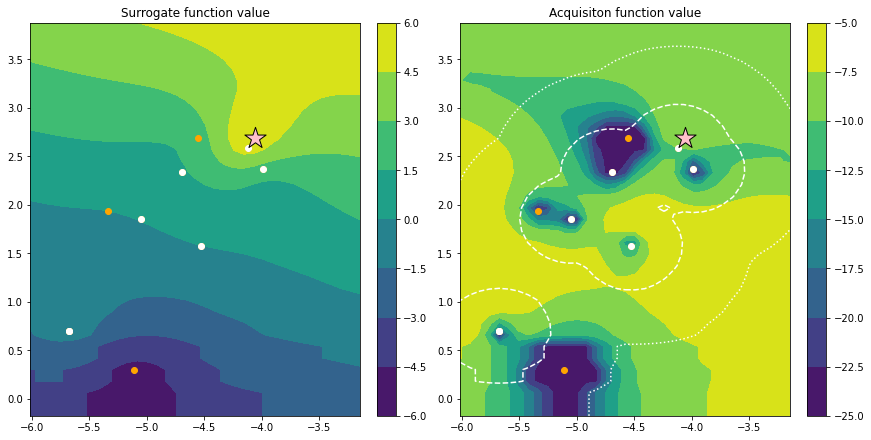

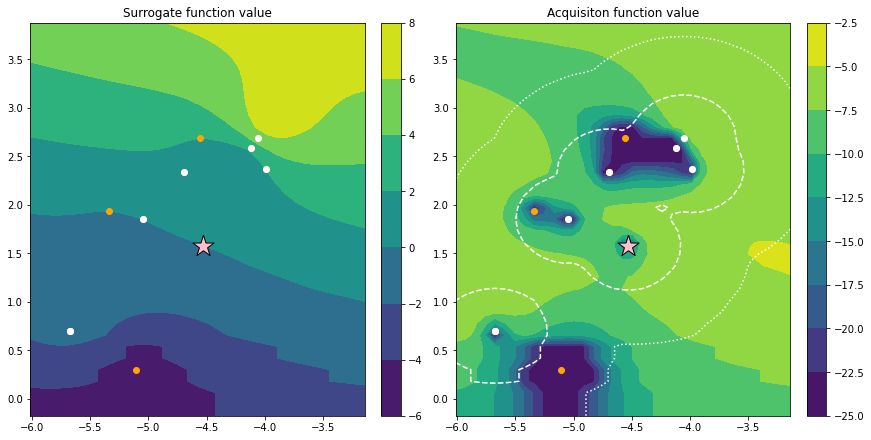

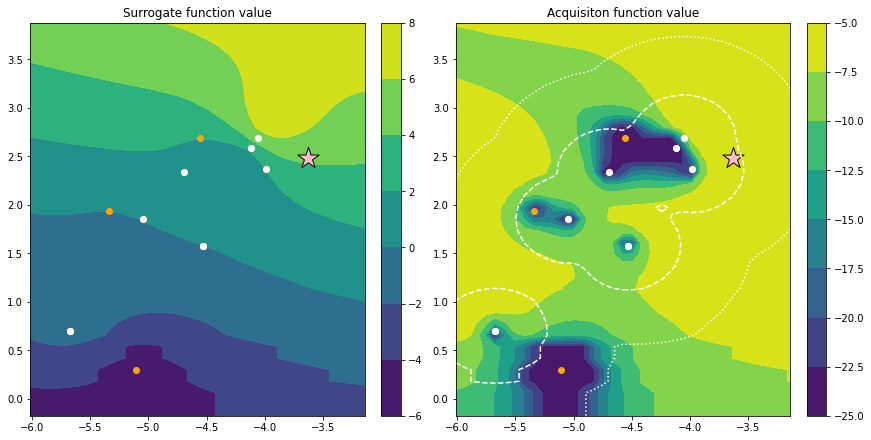

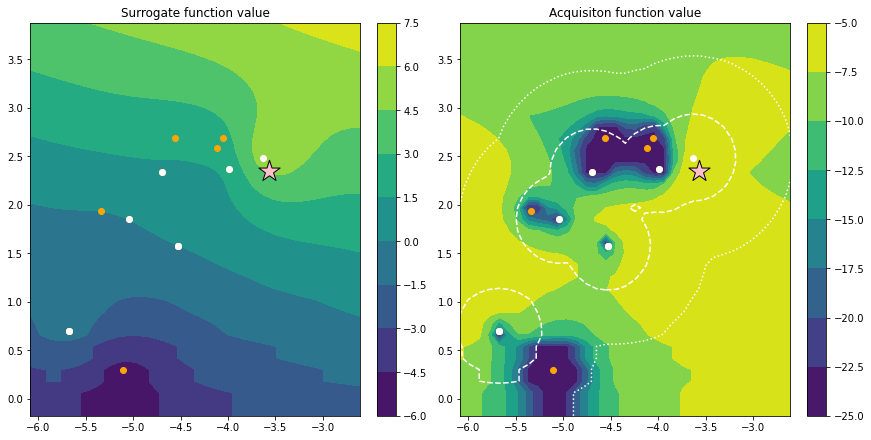

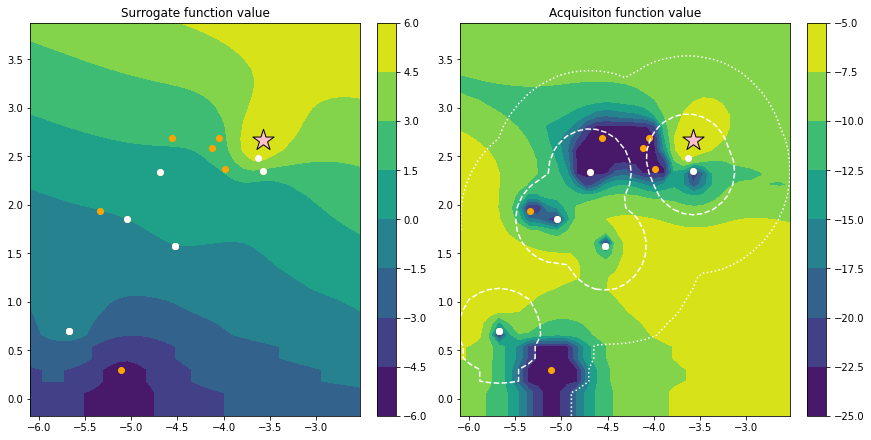

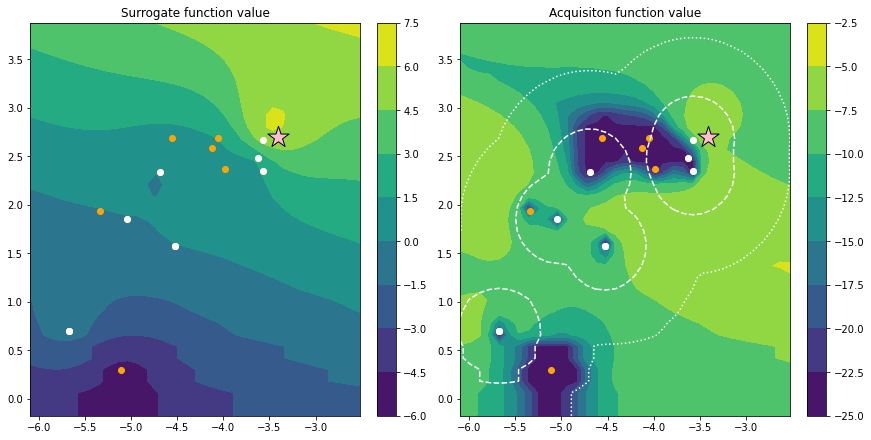

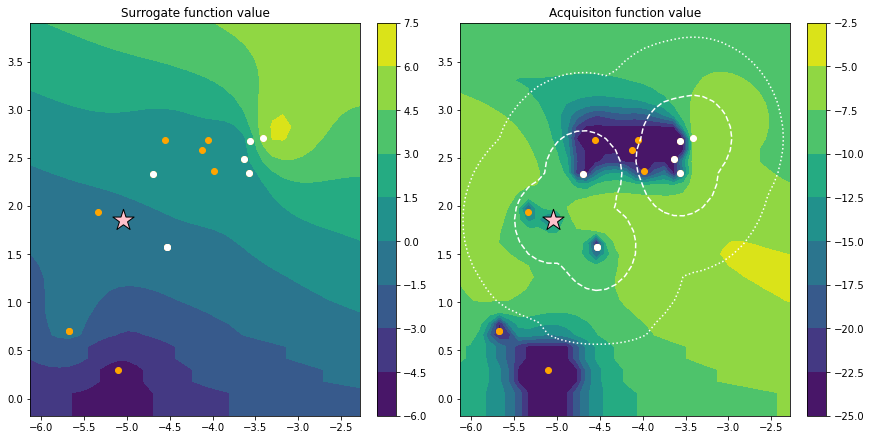

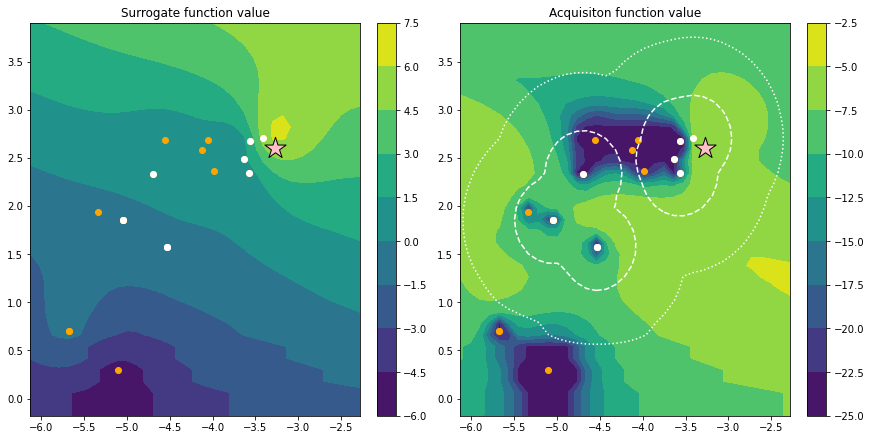

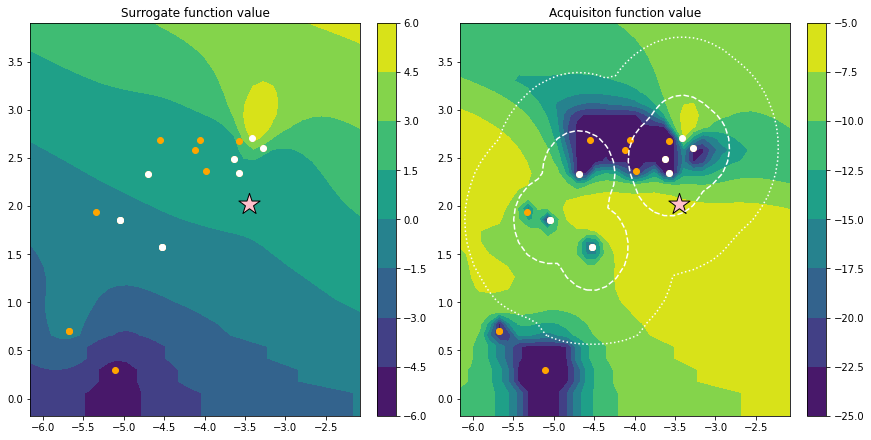

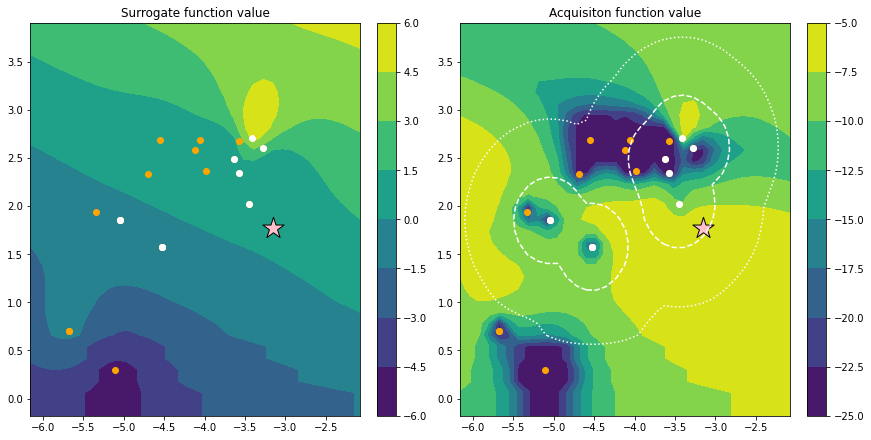

In [3]:

for i in range(20):
    suggest_out = plot_and_suggest()
    # logger.info(f"Suggestion details {suggest_out.log}")
    suggestion = suggest_out.suggestion
    observed_value = run_test_fn(suggestion)
    obs_out = carbs.observe(ObservationInParam(input=suggestion, output=observed_value, cost=suggestion["hidden_dim"]))